# **Sentiment analysis of 2020 Election tweets**

TEAM MEMBERS:
1. Tomas Perez Gutierrez(tomaspg@bu.edu)
2. Apoorv Upadhye(aupadhye@bu.edu), 
3. Janvi Vora(jaanviii@bu.edu), 
4. Surendranath Reddy Nagula(nsreddy@bu.edu) 

Execution time : 6 - 7 hrs

### Context
We used tweets from Kaggle and Twitter API to get a dataset on tweets 1 month prior to the 2020 US elections.

### Motivation
We wanted explore how tweets reflect the public sentiment in the event of a significant event such as the 2020 US elections. 
How can we use Machine Learning to find better predictions of the upcoming future elections that already have a lot of data on people's sentiments in the public domain?

### Data Preprocessing
1. We have joebiden.csv and donaldtrump.csv with tweets related to each presidential candidate.
Preprocessing/ cleaning involved including removal of hashtags, retweets, tweets outside the USA.
2. We filtered tweets for English language & also within a period of 1 month before election day.

### Model Used for NLP(getting the sentiment of the tweet)
1. TextBlob is a Python library for Natural Language Processing (NLP). TextBlob actively employed Natural Language ToolKit (NLTK) to accomplish its tasks. NLTK is a library that provides easy access to many lexical resources and allows users to deal with categorization, classification, and a variety of other tasks. TextBlob is a basic package that allows for lexicon based sentiment analysis.
2. Google cloud NLP API, Using Google's superior text analysis algorithm. Google Cloud Natural Language API is a cloud-based collection of strong machine learning models. It can do Sentiment Analysis, Entity Analysis, Syntax Analysis, Entity Sentiment Analysis, and Text Classification without labeled or training data. These models have been pre-trained on somewhat large datasets.

### Using the NLP Result
We use the NLP results from both texblob and GCP NLP API and provide it as the final label(sentiment) of the tweet and then create classification algorithms to predict the sentiment using actual tweets.

### Machine Learning Models Used
1. Logistic Regression, with the best success rate of 85.4%, is the Model used in the final prediction of the outcome.
2. Naive Bayes, using the Bayesian algorithm to predict the classification of the votes
3. Random Forest it's a combination of hundreds of decision trees that gives a representation of the most important feature
4. Gradient Boost Algorithm, Ensemble Learning technique that combines several weak learners(predictors with poor accuracy) into a strong learner(a model with factual accuracy). This works by each Model paying attention to its predecessor's mistakes.
5. Factorization Machines (FM) is a generic yet robust model framework especially well-suited to collaborative filtering recommendation problems
6. Support Vector Machines SVM is based on the idea of finding a hyperplane that best separates the features into different domains.
7. Decision Tree, these classifiers provide a direct value of the most critical parameter and then divide the parameters tree-wise and use Gini Index to get the most critical parameter.


### Visualization
1. After getting the best result via Logistic Regression as our top priority model, we display the results of each candidate's votes and prediction counts.
2. We are now using the prediction of our Model to get the winner in a single state by using (positive references-negative references).


### Final Results
1. We have predictions of state-wise winners, visualized using pyplotexpress
2. Joe Biden seems like a clear winner, however our predictions differ from the actual results and we've included our hypotheses  for the inaccuracy in predictions in the report.

In [ ]:
# Imports
import numpy as np
import pandas as pd
import re

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun May  1 21:04:36 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!pip install pyspark
# Spark Imports
from pyspark.sql import SparkSession
from pyspark.ml.feature import Tokenizer, RegexTokenizer, CountVectorizer, \
           StopWordsRemover, NGram, HashingTF, IDF, Word2Vec

from pyspark.sql.functions import explode, expr
from pyspark.ml.functions  import vector_to_array

from pyspark.sql.functions import length, size

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LogisticRegressionModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import MultilayerPerceptronClassifier

In [ ]:
# Visualization imports
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import seaborn as sns
import os
import plotly.express as pxw
import plotly.graph_objs as go
import collections
from collections import defaultdict


### Spark Initializer

In [ ]:
# Initializing Spark
spark = SparkSession.builder.appName("FinalML").getOrCreate()
sc = spark.sparkContext

### Data Loading

In [ ]:
from pyspark.sql.functions import lit

In [ ]:
# For colab
from google.colab import files
files.upload()

Saving joebiden.csv to joebiden.csv


**Joe Biden Data**

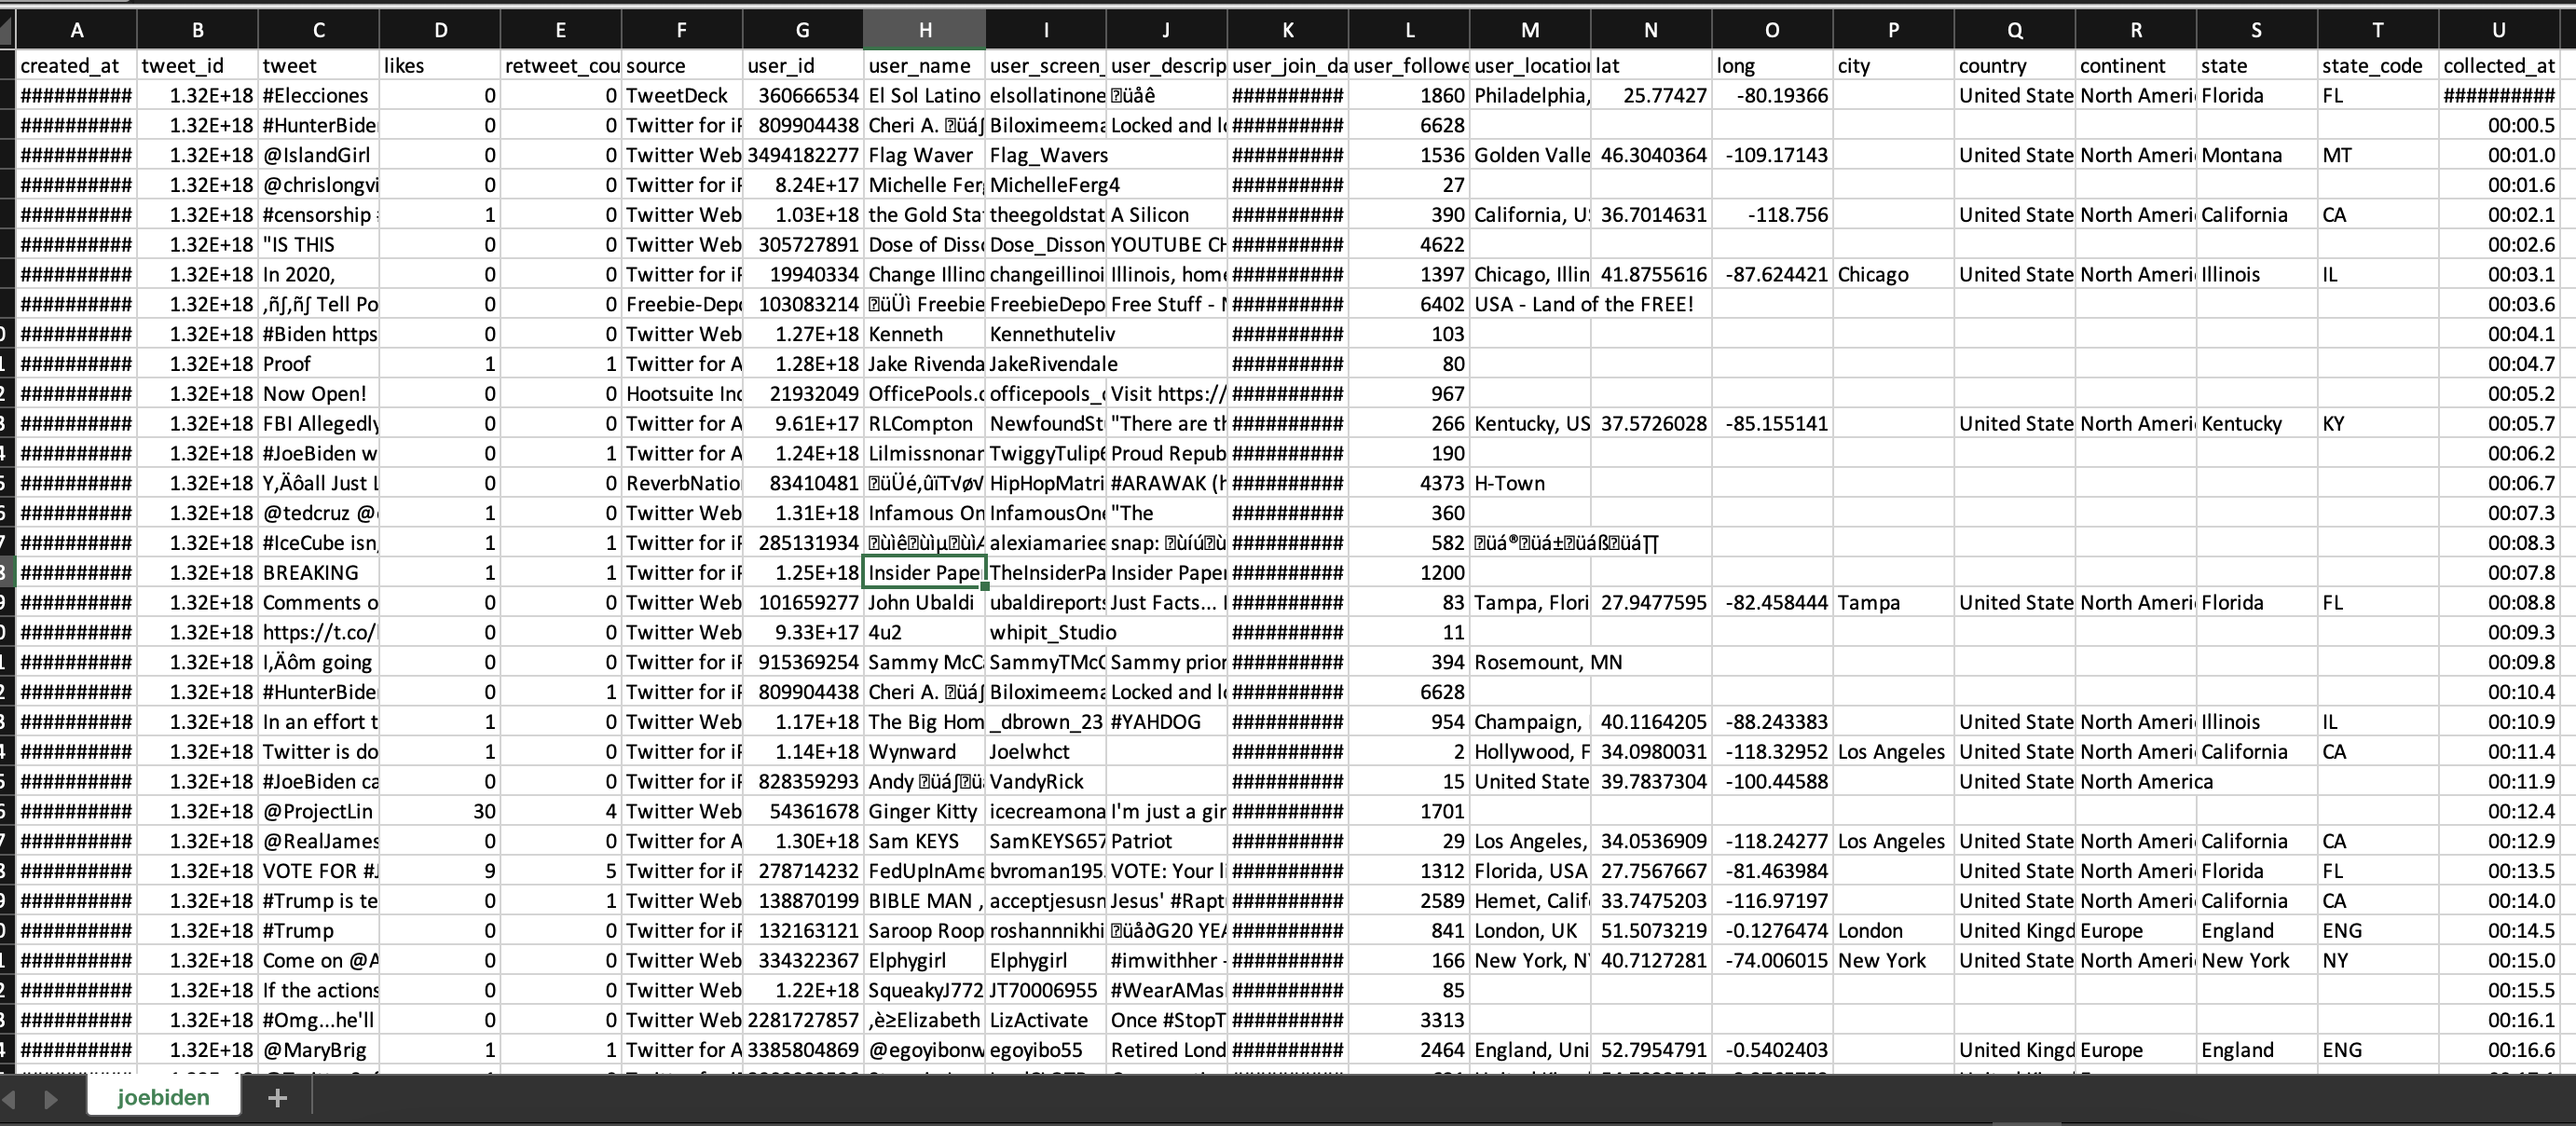

In [ ]:
# Loading Biden data with Spark
biden_df = spark.read.csv('joebiden.csv', inferSchema=True, header=True, sep=',')
biden_df = biden_df.dropna()
biden_df = biden_df.withColumn('candidate', lit('Joe Biden'))

**Donald Trump Data**

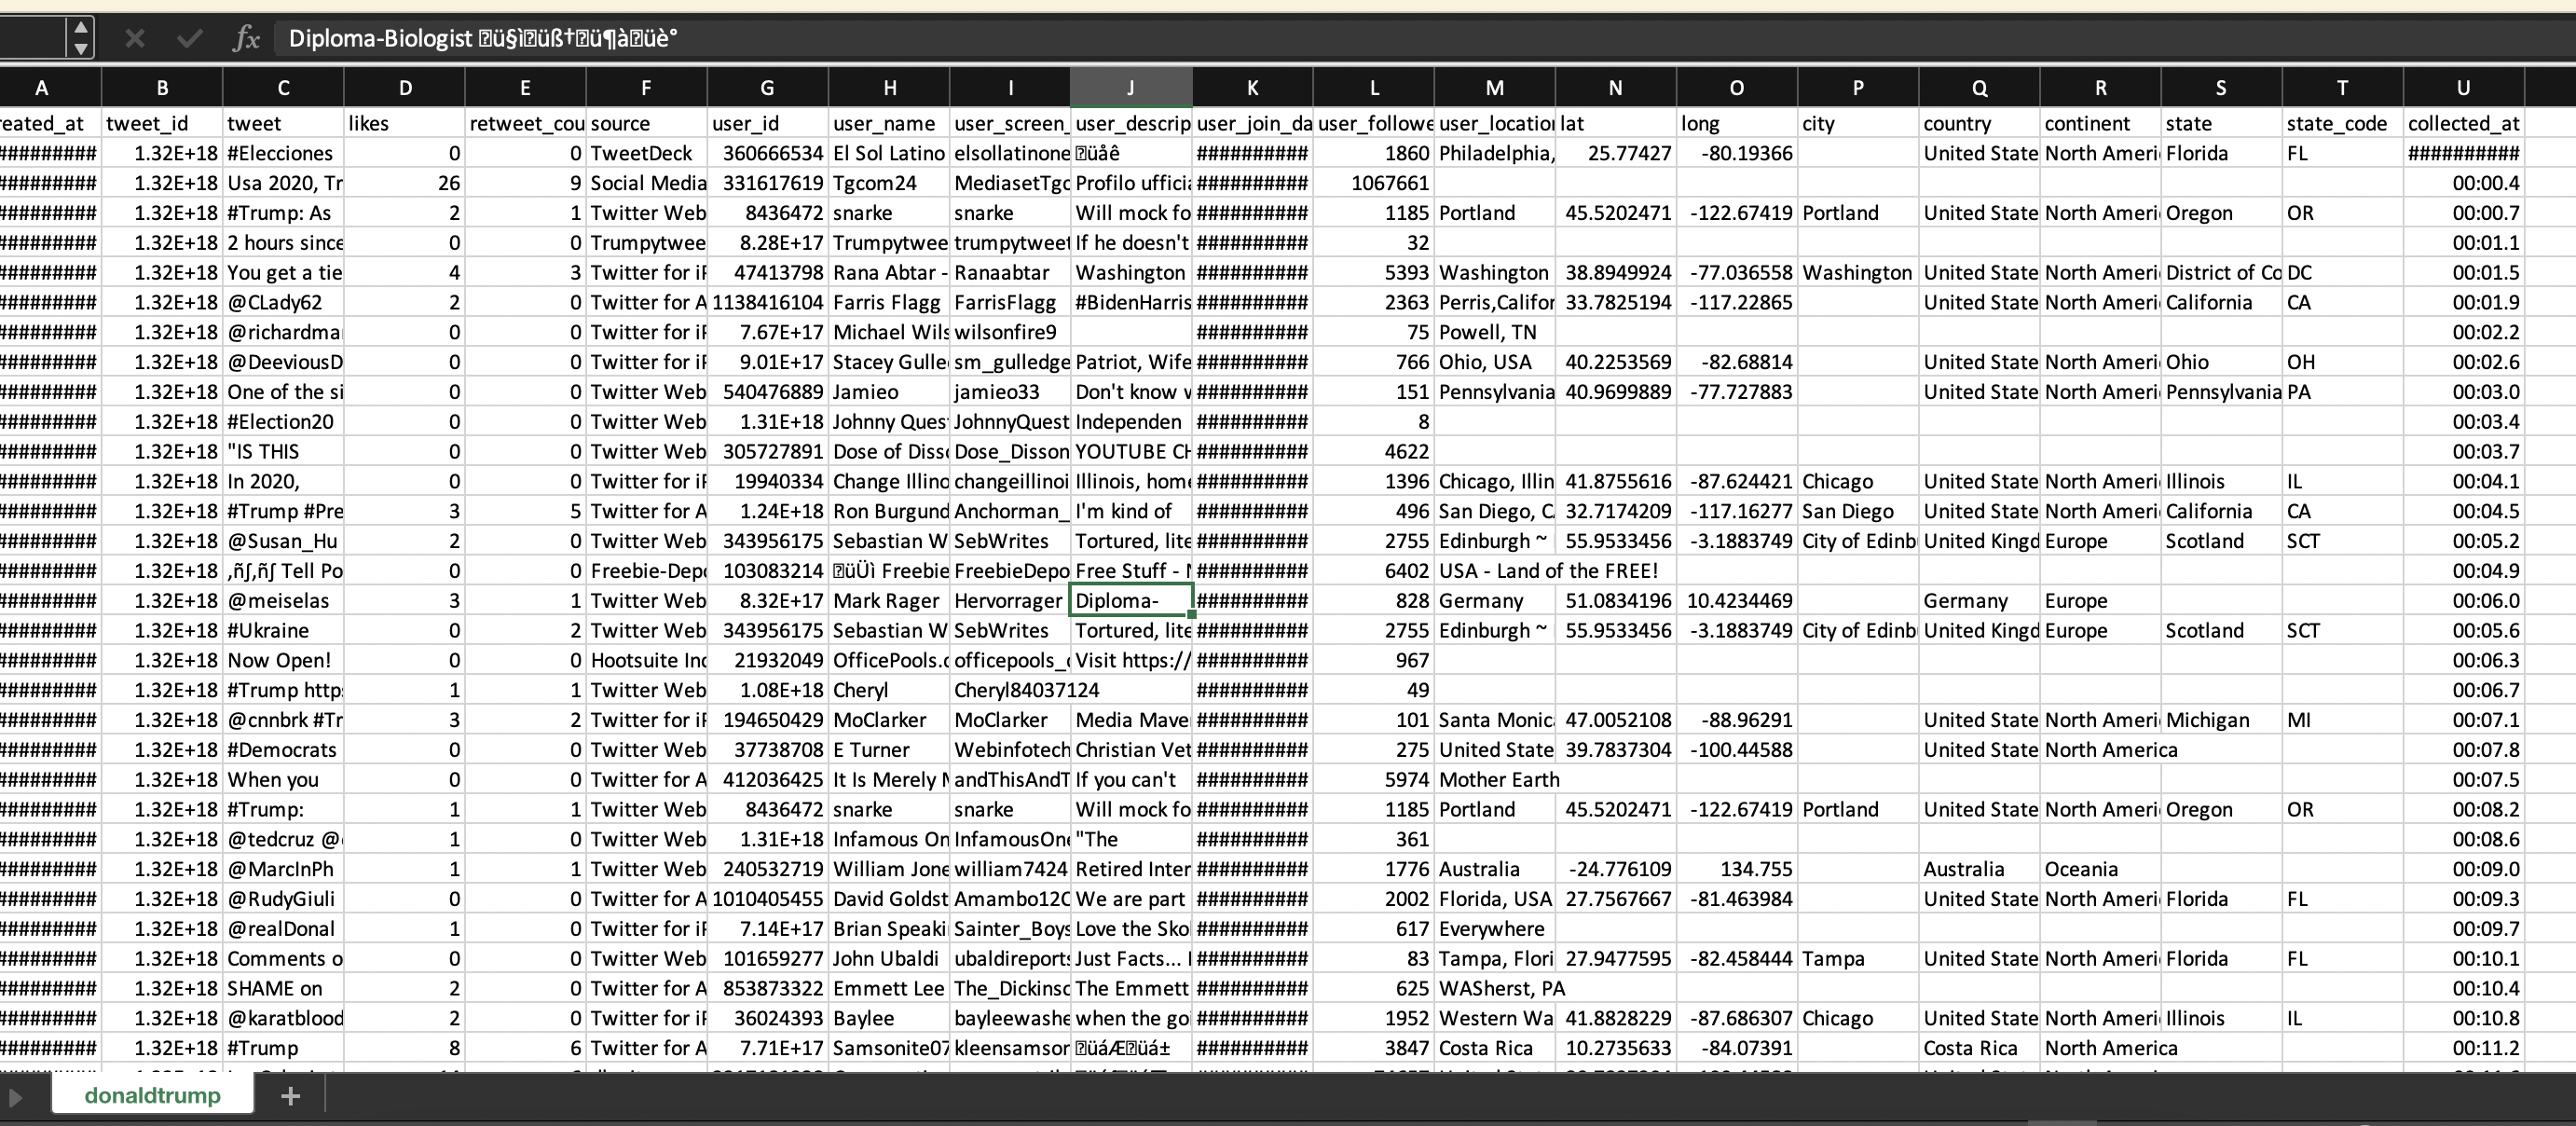

In [ ]:
# For colab
files.upload()

Saving donaldtrump.csv to donaldtrump.csv


In [ ]:
# Loading Trump data with Spark
trump_df = spark.read.csv('donaldtrump.csv', inferSchema=True, header=True, sep=',')
trump_df = trump_df.dropna()
trump_df = trump_df.withColumn('candidate', lit('Donald Trump'))

In [ ]:
biden_df.count()

70120

In [ ]:
# Merging Dataframes
elections_df = biden_df.union(trump_df)

In [ ]:
elections_df.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- created_at: string (nullable = true)
 |-- tweet_id: string (nullable = true)
 |-- tweet: string (nullable = true)
 |-- likes: string (nullable = true)
 |-- retweet_count: string (nullable = true)
 |-- source: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- user_name: string (nullable = true)
 |-- user_screen_name: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_join_date: string (nullable = true)
 |-- user_followers_count: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- continent: string (nullable = true)
 |-- state: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- collected_at: string (nullable = true)
 |-- language: string (nullable = true)
 |-- candidate: string (nullable = false)



## Data exploration & preprocessing


### Twitter Data Filtering / Formatting

In [ ]:
from pyspark.sql.functions import *

In [ ]:
import datetime
# Selecting Relevant Colums
elections_filtered_df = elections_df.select(elections_df.created_at.alias('date'),'tweet','country','state','state_code','Candidate')
# Filtering US Tweets
elections_filtered_df = elections_filtered_df.filter(elections_filtered_df.country == 'United States of America')
# Giving Format to dates
elections_filtered_df = elections_filtered_df.withColumn('date',elections_filtered_df.date[0:10])
elections_filtered_df = elections_filtered_df.withColumn('date',to_date(col("date"),"yyyy-MM-dd"))
# Filtering Tweets 'October 16th 2020' - 'Day of Elections'
elections_filtered_df = elections_filtered_df.filter((elections_filtered_df.date < datetime.date(2020,11,3)) & (elections_filtered_df.date > datetime.date(2020,10,8)))

In [ ]:
# Number of data
elections_filtered_df.count()

58225

**Is the data balanced for each candidate?**

In [ ]:
# Tweets count per Candidate
elections_filtered_df.groupBy('candidate').count().show()

+------------+-----+
|   candidate|count|
+------------+-----+
|   Joe Biden|24517|
|Donald Trump|33708|
+------------+-----+



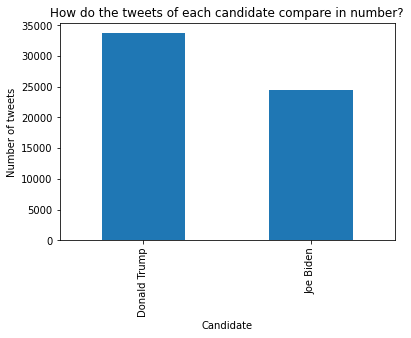

In [ ]:
# Converting data to Pandas dataframe for Plotting
election_pandas = elections_filtered_df.toPandas()

election_pandas.groupby('Candidate')['tweet'].count().plot.bar()
plt.xlabel("Candidate")
plt.ylabel('Number of tweets')
plt.title('How do the tweets of each candidate compare in number?')
plt.show()

**How many tweets do we have per State?**

In [ ]:
# Tweets per State
elections_filtered_df.groupBy('state').count().orderBy(desc('count')).show(50)

+--------------------+-----+
|               state|count|
+--------------------+-----+
|          California|11617|
|            New York|10944|
|               Texas| 5071|
|District of Columbia| 4542|
|             Florida| 3914|
|            Illinois| 2561|
|        Pennsylvania| 2192|
|                Ohio| 1934|
|             Georgia| 1413|
|       Massachusetts| 1401|
|            Colorado| 1083|
|              Nevada| 1071|
|             Arizona| 1003|
|          Washington|  987|
|      North Carolina|  753|
|              Oregon|  728|
|           Tennessee|  715|
|            Michigan|  714|
|            Missouri|  640|
|           Minnesota|  565|
|            Maryland|  452|
|            Virginia|  415|
|             Indiana|  350|
|           Louisiana|  323|
|          New Jersey|  308|
|           Wisconsin|  283|
|             Alabama|  238|
|              Hawaii|  197|
|            Kentucky|  193|
|               Idaho|  157|
|      South Carolina|  148|
|          New

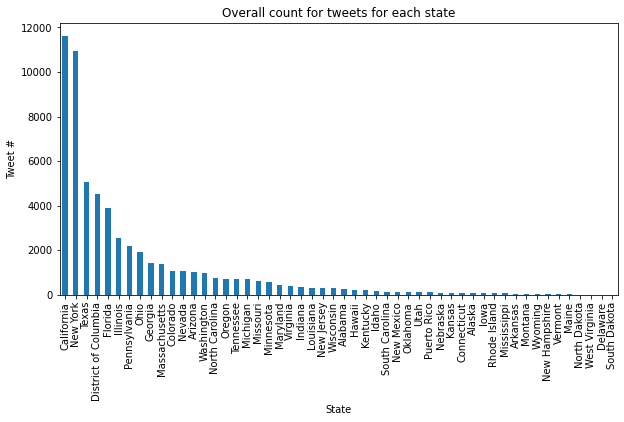

In [ ]:
plt.figure(figsize=(10,5))
election_pandas.groupby('state')['tweet'].count().sort_values(ascending=False).plot.bar()
plt.xlabel('State')
plt.ylabel('Tweet #')
plt.title('Overall count for tweets for each state')
plt.show()

**How many tweets do we have per State and Candidate?**

In [ ]:
# Tweets per State & Candidate
elections_filtered_df.groupBy('state','candidate').count().orderBy('state','candidate').show()

+--------------------+------------+-----+
|               state|   candidate|count|
+--------------------+------------+-----+
|             Alabama|Donald Trump|   97|
|             Alabama|   Joe Biden|  141|
|              Alaska|Donald Trump|   35|
|              Alaska|   Joe Biden|   51|
|             Arizona|Donald Trump|  532|
|             Arizona|   Joe Biden|  471|
|            Arkansas|Donald Trump|   35|
|            Arkansas|   Joe Biden|   21|
|          California|Donald Trump| 7180|
|          California|   Joe Biden| 4437|
|            Colorado|Donald Trump|  689|
|            Colorado|   Joe Biden|  394|
|         Connecticut|Donald Trump|   49|
|         Connecticut|   Joe Biden|   37|
|            Delaware|Donald Trump|    5|
|            Delaware|   Joe Biden|    4|
|District of Columbia|Donald Trump| 2992|
|District of Columbia|   Joe Biden| 1550|
|             Florida|Donald Trump| 2323|
|             Florida|   Joe Biden| 1591|
+--------------------+------------

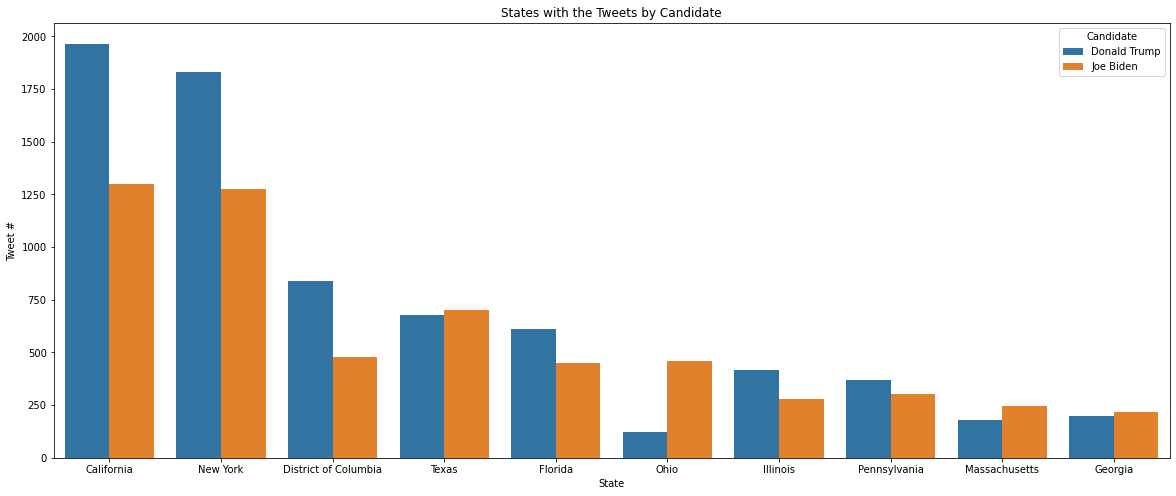

In [ ]:
top_states = election_pandas.groupby('state')['tweet'].count().sort_values(ascending=False).index.tolist()[:10]

country_df = election_pandas.groupby(['state','Candidate'])['tweet'].count().reset_index()
plt.figure(figsize=(20,8))
country_df = country_df.sort_values(by='tweet', ascending=False)
country_df = country_df[country_df['state'].isin(top_states)]
sns.barplot(data=country_df,x='state',y='tweet',hue='Candidate')
plt.xlabel('State')
plt.ylabel('Tweet #')
plt.title('States with the Tweets by Candidate')
plt.show()

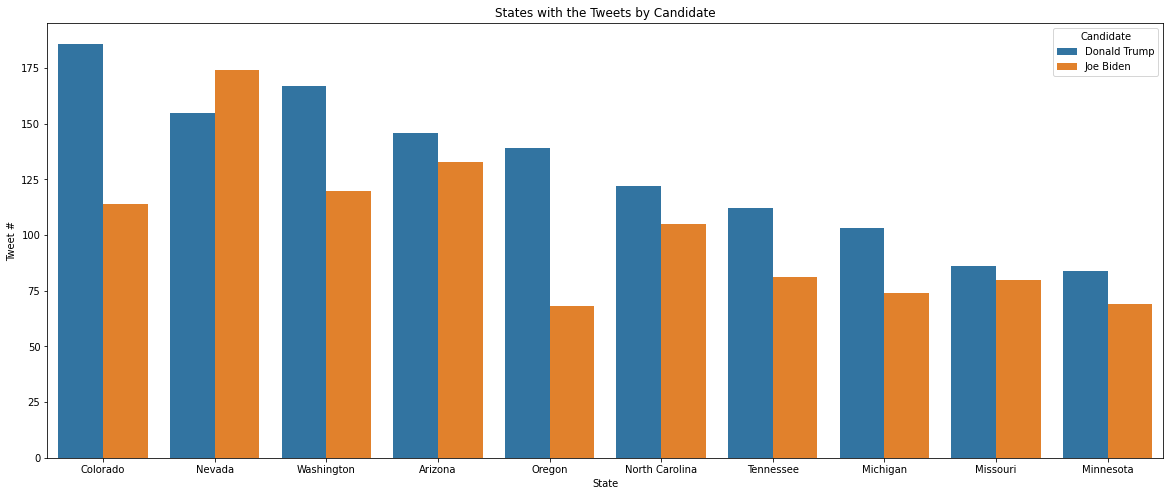

In [ ]:
top_states = election_pandas.groupby('state')['tweet'].count().sort_values(ascending=False).index.tolist()[10:20]

country_df = election_pandas.groupby(['state','Candidate'])['tweet'].count().reset_index()
plt.figure(figsize=(20,8))
country_df = country_df.sort_values(by='tweet', ascending=False)
country_df = country_df[country_df['state'].isin(top_states)]
sns.barplot(data=country_df,x='state',y='tweet',hue='Candidate')
plt.xlabel('State')
plt.ylabel('Tweet #')
plt.title('States with the Tweets by Candidate')
plt.show()

In [ ]:
from pyspark.sql import functions as F

# Cleaning-Up Tweet
# =================
# Lowercasing all the tweets
elections_filtered_df = elections_filtered_df.withColumn('tweet', lower(col('tweet')))
# Removing Links
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', r'http\S+', ''))
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', r'www.\S+', ''))
# Removing hashtags and mentions
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', '#', ''))
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', '@', ''))
# Removing RTs
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', 'RT', ''))
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', ':', ''))
# Removing punctuactions
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', '[()!?]', ''))
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', '\[.*?\]', ''))
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', '"', ''))
elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', ',', ''))
# Removing non-alphanumeric characters
#elections_filtered_df = elections_filtered_df.withColumn('tweet', F.regexp_replace('tweet', '[^a-zA-Z0-9 -]', '  '))

**What are the most frequent key words?**

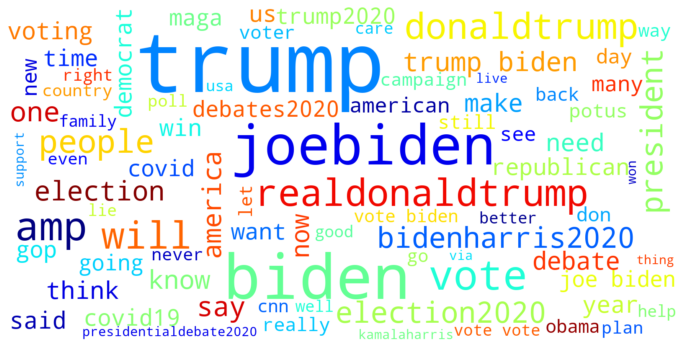

In [ ]:
# Converting data into Pandas for Plotting
election_pandas = elections_filtered_df.toPandas()

# Word Cloud
def word_cloud(wd_list):
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear")

word_cloud(election_pandas['tweet'].sample(2000))

**Which candidate had more social media representation?**

In [ ]:
def get_day(timestamp):
    day = timestamp
    return day

time_df = election_pandas.dropna(subset=['tweet'])
time_df['date'] = time_df['date'].apply(get_day)
time_df = time_df.groupby(['Candidate', 'date'])['tweet'].count().reset_index()

fig = pxw.line(time_df, x='date', y='tweet', color='Candidate', 
    labels={
                     "date": "Date",
                     "tweet": "Tweet #",
    },
    title="Daily Number of Tweets per Candidate")

fig.show()

In [ ]:
state_df = election_pandas[election_pandas['country'] == 'United States of America'].dropna(subset=['state_code']).groupby(['state_code','Candidate'])['tweet'].count().reset_index()
state_df = state_df.set_index(['Candidate', 'state_code']).unstack(level=0)

def getDiff(state):
    total = state[1] + state[0]
    diff = state[1] - state[0]  # trump - biden
    
    return diff/total

state_df = state_df.apply(getDiff, axis=1).reset_index().rename({0: 'diff'}, axis=1)

In [188]:
# Visualization of USA map by number of tweets for each candidate
# Red - Trump, Blue - Biden
fig = pxw.choropleth(state_df,
                    locations='state_code',
                    locationmode="USA-states",
                    scope='usa',
                    color='diff',
                    color_continuous_scale=('#ff4040', '#4040ff'),
                    range_color=(0, 0.2),
                    color_continuous_midpoint=0,
                    )
fig.show()

In [ ]:
election_pandas

Index        date                                              tweet  \
0          0  10/15/2020  corruption bidencrimefamily joebiden hunterbid...   
1          1  10/15/2020  hunterbiden hunterbidenemails joebiden bidenha...   
2          2  10/15/2020  let’s do this people help the team out timefor...   
3          3  10/15/2020  my latest for theneutral biden trump nypost hu...   
4          4  10/15/2020  &amp; yeah pres is likely to get higher rating...   
...      ...         ...                                                ...   
16428   3428   11/2/2020  🇺🇸 ahead of electionday in the usa this is wha...   
16429   3429   11/2/2020                        👏🏽👏🏽👏🏽 politics biden trump   
16430   3430   11/2/2020  📣 new podcast ep. 977 | election day eve | the...   
16431   3431   11/2/2020  📣 new podcast treason show 54 on spreaker coro...   
16432   3432   11/2/2020  🤐🤐🤐🤐🤐  eleicoes2020  eleicoeseua trump  trump2...   

                        country                 state state_code  \
0      United States of America              New York         NY   
1      United States of America              New York         NY   
2      United States of America                Kansas         KS   
3      United States of America                 Texas         TX   
4      United States of America              New York         NY   
...                         ...                   ...        ...   
16428  United States of America  District of Columbia         DC   
16429  United States of America                 Texas         TX   
16430  United States of America         Massachusetts         MA   
16431  United States of America               Arizona         AZ   
16432  United States of America  District of Columbia         DC   

          Candidate  GCP_polarity textblob_sentiment  textblob_polarity  
0         Joe Biden             0            neutral           0.000000  
1         Joe Biden             1            neutral           0.000000  
2         Joe Biden             1            neutral           0.000000  
3         Joe Biden             2           positive           0.500000  
4         Joe Biden             2           positive           0.020000  
...             ...           ...                ...                ...  
16428  Donald Trump             0            neutral           0.000000  
16429  Donald Trump             0            neutral           0.000000  
16430  Donald Trump             2           positive           0.136364  
16431  Donald Trump             2           positive           0.136364  
16432  Donald Trump             2            neutral           0.000000  

[16433 rows x 10 columns]

In [ ]:
state_time_df = election_pandas[election_pandas['country'] == 'United States of America'].dropna(subset=['state_code'])
state_time_df['date_str'] = election_pandas['date'].apply(lambda x: str(x))
state_time_df = state_time_df.groupby(['state_code', 'Candidate', 'date_str'])['tweet'].count().reset_index()

state_time_df.head()

state_code     Candidate    date_str  tweet
0         AK  Donald Trump  10/20/2020      1
1         AK  Donald Trump  10/23/2020      3
2         AK  Donald Trump  10/27/2020      1
3         AK  Donald Trump  10/28/2020      2
4         AK  Donald Trump  10/31/2020      1

In [ ]:
# Play visualization to see variation of tweets over time
fig = pxw.choropleth(state_time_df,
                    locations='state_code',
                    locationmode='USA-states',
                    animation_frame='date_str',
                    scope='usa',
                    color='tweet',
                    color_continuous_scale=pxw.colors.sequential.Plasma,
                    range_color=(0, 250),
                    width=1000,
                    height=500
                    )
fig.show()

### Splitting data

We are going to use 30% of the data for training/testing the model and the other 70% for making predictions.

In [ ]:
# Splitting data
model_df, predicting_df = elections_filtered_df.randomSplit([0.3, 0.7], seed=1)

# Seeing if data from both candidates is balanced
model_df.groupBy('candidate').count().show()
predicting_df.groupBy('candidate').count().show()

+------------+-----+
|   candidate|count|
+------------+-----+
|   Joe Biden| 7287|
|Donald Trump|10146|
+------------+-----+

+------------+-----+
|   candidate|count|
+------------+-----+
|   Joe Biden|17230|
|Donald Trump|23562|
+------------+-----+



### **Sentiment Labeling with TextBlob**

In [ ]:
# Importing TextBlob
from textblob import TextBlob

In [ ]:
# Getting the Polarity
    # 1: Positive
    # 0: Negative

def get_textblob_sentiment(tweet):
    polarity = TextBlob(tweet).sentiment.polarity
    if(polarity > 0):
        return 1
    elif (polarity < 0):
        return 0
    else:
        return 2

def get_textblob_polarity(tweet):
    return TextBlob(tweet).sentiment.polarity

In [ ]:
election_pandas_textblob = model_df.toPandas()

In [ ]:
election_pandas_textblob['textblob_sentiment'] = election_pandas_textblob['tweet'].apply(lambda x: get_textblob_sentiment(x))
election_pandas_textblob['textblob_polarity'] = election_pandas_textblob['tweet'].apply(lambda x: get_textblob_polarity(x))

In [ ]:
election_pandas_textblob['textblob_sentiment']=election_pandas_textblob['textblob_sentiment'].replace(0,'negative')
election_pandas_textblob['textblob_sentiment']=election_pandas_textblob['textblob_sentiment'].replace(1,'positive')
election_pandas_textblob['textblob_sentiment']=election_pandas_textblob['textblob_sentiment'].replace(2,'neutral')

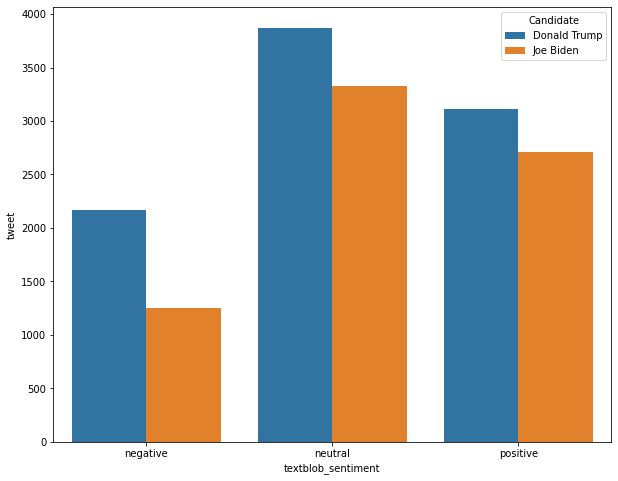

In [ ]:
sentiment_count_textblob = election_pandas.groupby(['textblob_sentiment', 'Candidate'])['tweet'].count().reset_index()
plt.figure(figsize=(10,8))
sns.barplot(data=sentiment_count_textblob, x='textblob_sentiment', y='tweet', hue='Candidate')
plt.show()

In [ ]:
textblob_polarity = udf(lambda x: get_textblob_polarity(x))
textblob_sentiment = udf(lambda x: get_textblob_sentiment(x))

spark.udf.register("textblob_polarity", textblob_polarity)
spark.udf.register("textblob_sentiment", textblob_sentiment)

model_df_textblob = model_df.withColumn('textblob_polarity',textblob_polarity('tweet').cast('double')) \
                    .withColumn('textblob_sentiment',textblob_sentiment('tweet').cast('double')).dropna()

###**Sentiment labeling with GCP**

Features of GCP Natural Language AI API - Sentiment analysis

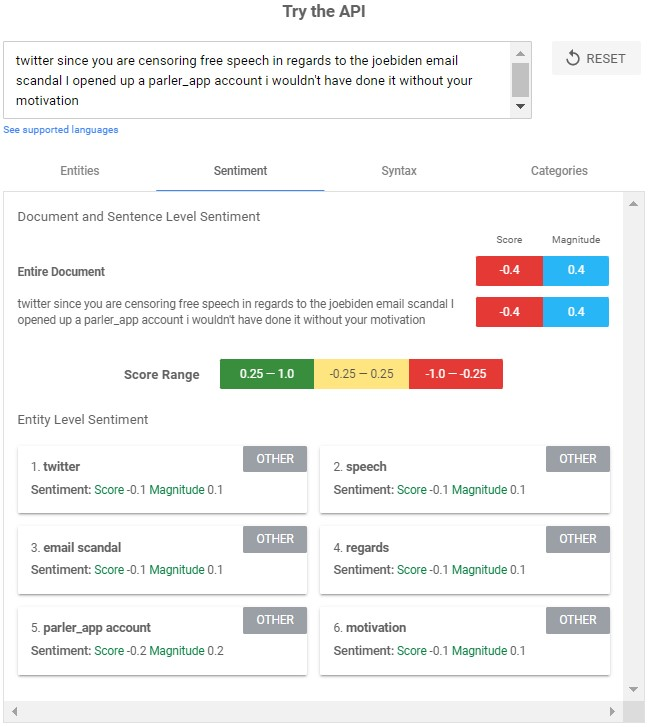

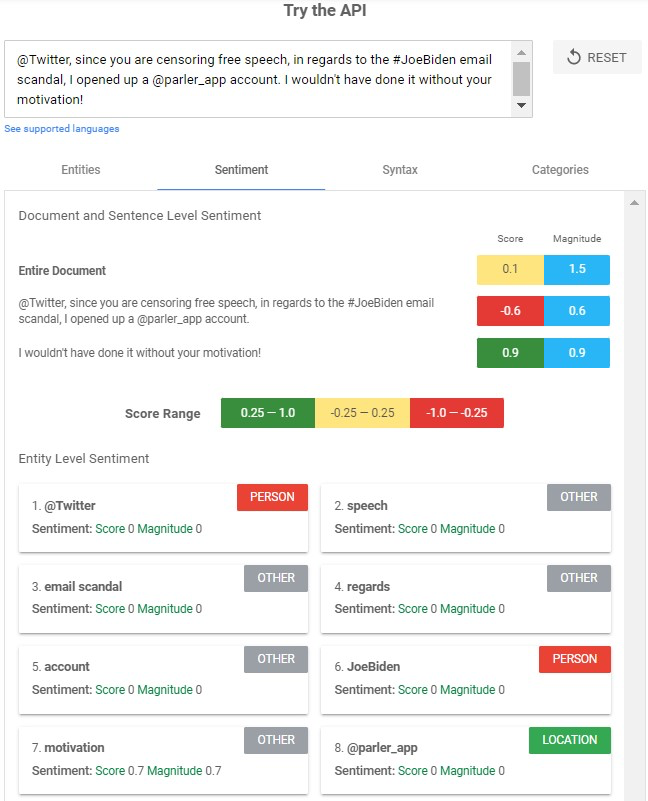

GCP NL AI API - Dependency graph for contextual understanding



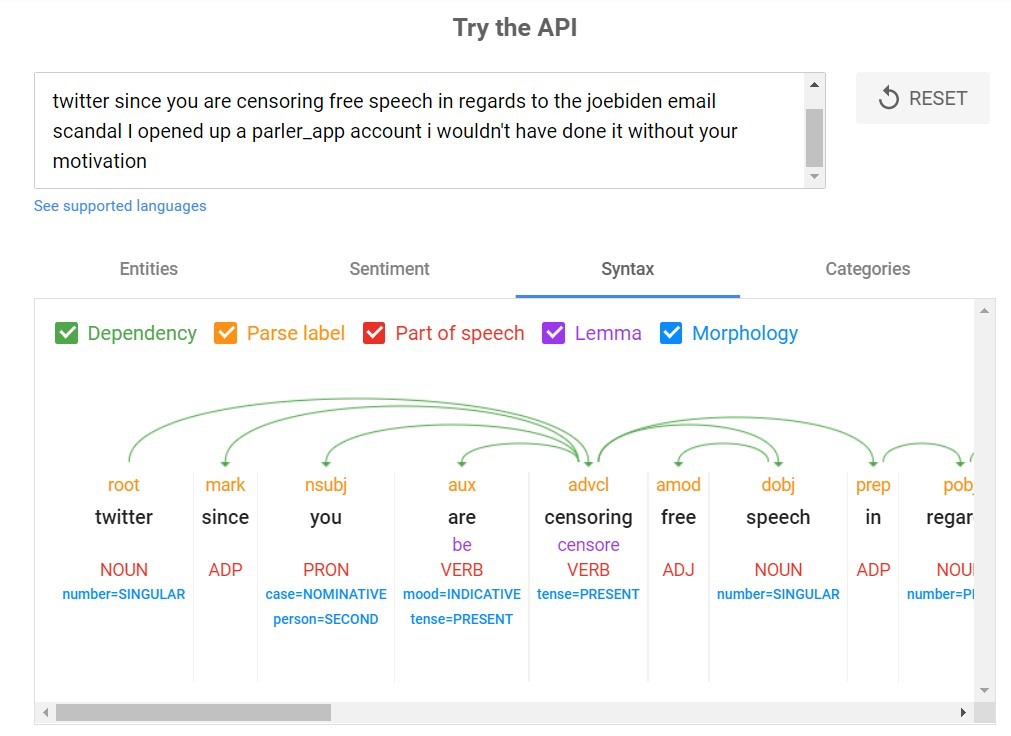

In [ ]:
# For colab
files.upload()

Saving Tweets_with_GCP.csv to Tweets_with_GCP.csv


{'Tweets_with_GCP.csv': b"Index,date,tweet,country,state,state_code,Candidate,GCP_polarity,GCP_sentiment_score\r\n0,10/15/2020,corruption bidencrimefamily joebiden hunterbiden 4moreyears corruptbiden joebidenisaliar crackpipebiden democrats quidprojoe vote waytooearly election election2020 elections2020 biden biden2020 2020election trending censorship usa,United States of America,New York,NY,Joe Biden,0,-0.7\r\n1,10/15/2020,hunterbiden hunterbidenemails joebiden bidenharris2020 biden2020,United States of America,New York,NY,Joe Biden,1,0.3\r\n2,10/15/2020,let\xe2\x80\x99s do this people help the team out timeforchange biden biden2020,United States of America,Kansas,KS,Joe Biden,1,0.6\r\n3,10/15/2020,my latest for theneutral biden trump nypost hunterbiden tech,United States of America,Texas,TX,Joe Biden,2,0\r\n4,10/15/2020,&amp; yeah pres is likely to get higher ratings. bc that\xe2\x80\x99s what moves votes \xf0\x9f\x98\x84 lot of folks will choose to watch trainwreck. not slightest bi

In [ ]:
model_df_gcp = spark.read.csv('Tweets_with_GCP.csv', inferSchema=True, header=True)
model_df_gcp = model_df_gcp.drop('GCP_sentiment_score')

In [ ]:
model_df_gcp.show(5)

+-----+----------+--------------------+--------------------+--------+----------+---------+------------+
|Index|      date|               tweet|             country|   state|state_code|Candidate|GCP_polarity|
+-----+----------+--------------------+--------------------+--------+----------+---------+------------+
|    0|10/15/2020|corruption bidenc...|United States of ...|New York|        NY|Joe Biden|           0|
|    1|10/15/2020|hunterbiden hunte...|United States of ...|New York|        NY|Joe Biden|           1|
|    2|10/15/2020|let’s do this peo...|United States of ...|  Kansas|        KS|Joe Biden|           1|
|    3|10/15/2020|my latest for the...|United States of ...|   Texas|        TX|Joe Biden|           2|
|    4|10/15/2020|&amp; yeah pres i...|United States of ...|New York|        NY|Joe Biden|           2|
+-----+----------+--------------------+--------------------+--------+----------+---------+------------+
only showing top 5 rows



In [ ]:
election_pandas_gcp = model_df_gcp.toPandas()

In [ ]:
election_pandas_gcp['GCP_polarity']=election_pandas_gcp['GCP_polarity'].replace(0,'negative')
election_pandas_gcp['GCP_polarity']=election_pandas_gcp['GCP_polarity'].replace(1,'positive')
election_pandas_gcp['GCP_polarity']=election_pandas_gcp['GCP_polarity'].replace(2,'neutral')

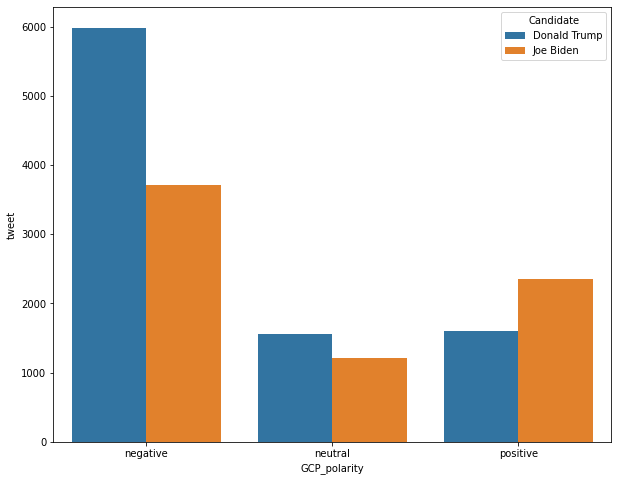

In [ ]:
sentiment_count_gcp = election_pandas_gcp.groupby(['GCP_polarity', 'Candidate'])['tweet'].count().reset_index()
plt.figure(figsize=(10,8))
sns.barplot(data=sentiment_count_gcp, x='GCP_polarity', y='tweet', hue='Candidate')
plt.show()

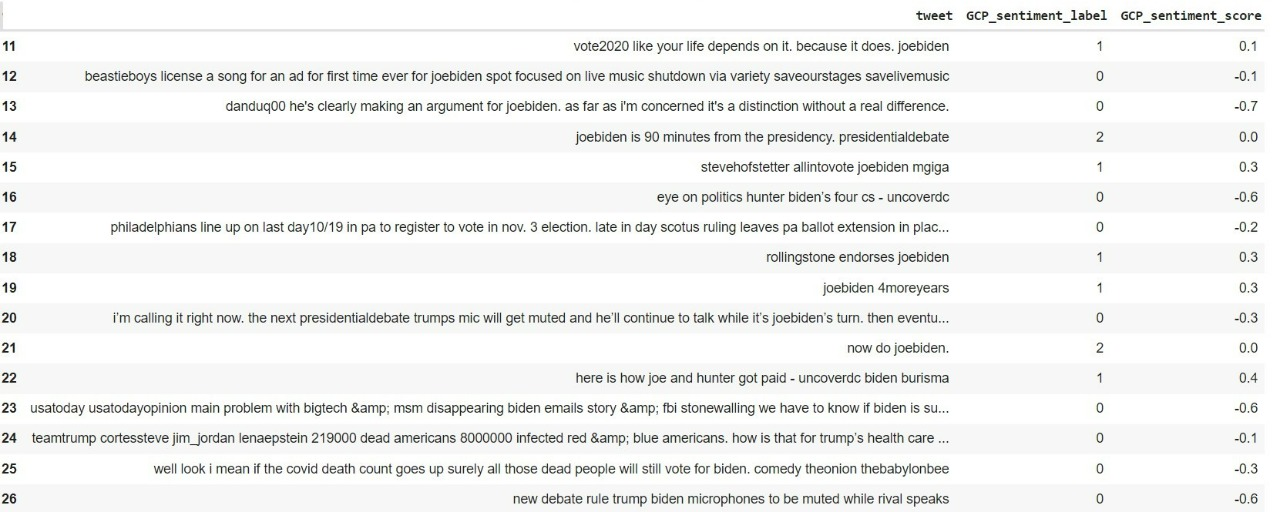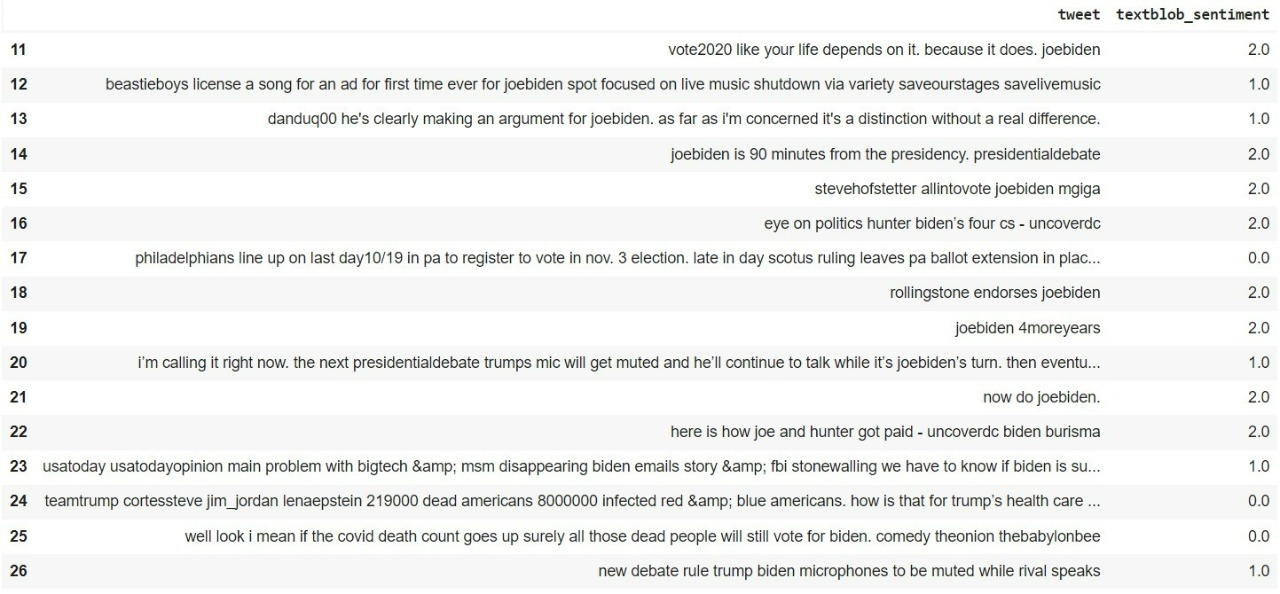

In [ ]:
# Filter NEUTRAL Sentiments - Textblob
model_df_textblob = model_df_textblob.filter(model_df_textblob.textblob_sentiment != 2).withColumn('textblob_sentiment', col('textblob_sentiment').cast('double'))
model_df_textblob.groupBy('textblob_sentiment').count().orderBy('textblob_sentiment').show()

+------------------+-----+
|textblob_sentiment|count|
+------------------+-----+
|               0.0| 3144|
|               1.0| 4930|
+------------------+-----+



In [ ]:
# Filter NEUTRAL Sentiments - GCP
model_df_gcp = model_df_gcp.filter(model_df_gcp.GCP_polarity != 2).withColumn('GCP_polarity', col('GCP_polarity').cast('double'))
model_df_gcp.groupBy('GCP_polarity').count().orderBy('GCP_polarity').show()

+------------+-----+
|GCP_polarity|count|
+------------+-----+
|         0.0| 9701|
|         1.0| 3964|
+------------+-----+



In [ ]:
# Regex Tokenizer
tokenizer = RegexTokenizer(inputCol="tweet", 
                           outputCol="raw_tokens",
                           pattern= "\\W")
rawTokenizedDF = tokenizer.transform(model_df_textblob)

# StopWords Remover
remover = StopWordsRemover(inputCol='raw_tokens',
                           outputCol='clean_tokens')
cleanTokenizedDF = remover.transform(rawTokenizedDF)
cleanTokenizedDF = cleanTokenizedDF.withColumn('num_tokens', size(cleanTokenizedDF['clean_tokens']))

# Count Vectorizer
countVectorizer = CountVectorizer(inputCol='clean_tokens',
                                  outputCol='raw_features')
cv_model = countVectorizer.fit(cleanTokenizedDF)
cv_df = cv_model.transform(cleanTokenizedDF)

# rescaling data
idf = IDF(inputCol="raw_features", outputCol="idf_features")
idfModel = idf.fit(cv_df)
rescaledData = idfModel.transform(cv_df)

In [ ]:
rescaledData.show()

+-----+----------+--------------------+--------------------+--------------------+----------+---------+------------+--------------------+------------------+--------------------+--------------------+----------+--------------------+--------------------+
|Index|      date|               tweet|             country|               state|state_code|Candidate|GCP_polarity|   textblob_polarity|textblob_sentiment|          raw_tokens|        clean_tokens|num_tokens|        raw_features|        idf_features|
+-----+----------+--------------------+--------------------+--------------------+----------+---------+------------+--------------------+------------------+--------------------+--------------------+----------+--------------------+--------------------+
|    6|10/15/2020|.nbc wth djt canc...|United States of ...|            New York|        NY|Joe Biden|           0|-0.09999999999999999|               0.0|[nbc, wth, djt, c...|[nbc, wth, djt, c...|        25|(18985,[2,31,87,1...|(18985,[2,31,87,1.

VISUALIZATION OF AREA UNDER THE CURVE

In [ ]:
def areaUnderROC(myModel):
    trainingSummary = myModel.summary
    roc = trainingSummary.roc.toPandas()
    plt.plot(roc['FPR'],roc['TPR'])
    plt.ylabel('False Positive Rate')
    plt.xlabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))
    return trainingSummary

## Classifications Models

#### Logistic Regression

In [ ]:
# Logistic Regression
#====================

# Vector Assembler
vecAssembler = VectorAssembler(inputCols=['idf_features', 'num_tokens'], 
outputCol='features')
dataset = vecAssembler.transform(rescaledData)

# Splitting data into training/test sets
training_df, test_df = dataset.randomSplit([0.80,0.20], seed=1)

#Building the model
log_reg = LogisticRegression(featuresCol='features', labelCol='textblob_sentiment')

# Training the model
lr_model = log_reg.fit(training_df)

# Testing the model
lr_result = lr_model.transform(test_df)
lr_result.groupBy('candidate','prediction').pivot('textblob_sentiment').count().show()

+------------+----------+---+---+
|   candidate|prediction|0.0|1.0|
+------------+----------+---+---+
|   Joe Biden|       1.0| 77|395|
|   Joe Biden|       0.0|159| 70|
|Donald Trump|       1.0|104|407|
|Donald Trump|       0.0|274|131|
+------------+----------+---+---+



In [ ]:
lr_result.groupBy('candidate','prediction').pivot('GCP_polarity').count().show()

+------------+----------+---+---+
|   candidate|prediction|  0|  1|
+------------+----------+---+---+
|   Joe Biden|       1.0|289|183|
|   Joe Biden|       0.0|201| 28|
|Donald Trump|       1.0|369|142|
|Donald Trump|       0.0|373| 32|
+------------+----------+---+---+



In [ ]:
# Multi-Class Evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="textblob_sentiment", predictionCol="prediction",
    metricName="accuracy")

In [ ]:
# Create Parameter-Grid for Cross Validation
lrparamGrid = ParamGridBuilder() \
    .addGrid(log_reg.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(log_reg.elasticNetParam, [0.5, 0.7, 0.9]) \
    .addGrid(log_reg.maxIter, [1, 5, 10])\
    .build()

# 10-Fold Cross Validator
lrcv = CrossValidator(estimator = log_reg,
                    estimatorParamMaps = lrparamGrid,
                    evaluator = evaluator,
                    numFolds = 10)

In [ ]:
# Fitting Cross-Validation to get the Best Model
lcrvModel = lrcv.fit(training_df)
lr_bestModel = lcrvModel.bestModel

print(lr_bestModel.getRegParam())
print(lr_bestModel.getElasticNetParam())
print(lr_bestModel.getMaxIter())

0.01
0.5
10


In [178]:
# Evaluating the accuracy of the model with the test set
# Predictions with the test set
predictions =lr_bestModel.transform(test_df)

# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="textblob_sentiment", predictionCol="prediction",
    metricName="accuracy")

accuracy_lr = evaluator.evaluate(predictions)
print ("Model Accuracy: ", accuracy_lr)

Model Accuracy:  0.852195423623995


In [179]:
# Area Under the curve (AUC)
# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="textblob_sentiment", predictionCol="prediction")

auc_lc = evaluator.evaluate(predictions)
print ("AUC: ", auc_lc)

AUC:  0.8488837446892383


In [180]:
def printConfusionMatrix(predictions):
    # Confussion Matrix
  true_positives = predictions[(predictions.sentiment == 1) & 
      (predictions.prediction == 1)].count()

  true_negatives = predictions[
      (predictions.sentiment == 0) & 
      (predictions.prediction == 0)].count()

  false_positives = predictions[
      (predictions.sentiment == 0) & 
      (predictions.prediction == 1)].count()

  false_negatives = predictions[
      (predictions.sentiment == 1) & 
      (predictions.prediction == 0)].count()

  print ("TN =", true_negatives, "  ", "FP =", false_positives)
  print ("FP =", false_negatives, "   ", "TP =", true_positives)

In [ ]:
type(log_reg)

pyspark.ml.classification.LogisticRegression

/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning:

Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.



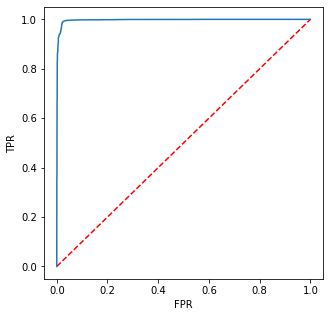

In [181]:
plt.figure(figsize=(5,5))
plt.plot([0, 1], [0, 1], 'r--')
plt.plot(lr_bestModel.summary.roc.select('FPR').collect(),
         lr_bestModel.summary.roc.select('TPR').collect())
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

#### Naive Bayes

In [ ]:
from pyspark.ml.classification import NaiveBayes

In [ ]:
# Naive Bayes
#====================

#Building the model
naive_bayes = NaiveBayes(featuresCol='features', labelCol='sentiment')

# Training the model
naive_bayes_model = naive_bayes.fit(training_df)

# Testing the model
nb_result = naive_bayes_model.transform(test_df)
nb_result.groupBy('prediction').pivot('sentiment').count().show()

+----------+---+---+
|prediction|0.0|1.0|
+----------+---+---+
|       0.0|207|155|
|       1.0| 77|314|
+----------+---+---+



In [ ]:
# Multi-Class Evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment", predictionCol="prediction",
    metricName="accuracy")

In [ ]:
# Create Parameter-Grid for Cross Validation
nbparamGrid = ParamGridBuilder() \
    .addGrid(naive_bayes.smoothing, [0.0, 0.1, 10.0, 100.0]) \
    .build()

# 10-Fold Cross Validator
nbcv = CrossValidator(estimator = naive_bayes,
                    estimatorParamMaps = nbparamGrid,
                    evaluator = evaluator,
                    numFolds = 10)

In [ ]:
# Fitting Cross-Validation to get the Best Model
nbrvModel = nbcv.fit(training_df)
nb_bestModel = nbrvModel.bestModel


In [ ]:
print(nb_bestModel.getSmoothing())

10.0


In [ ]:
# Evaluating the accuracy of the model with the test set
# Predictions with the test set
predictions = nb_bestModel.transform(test_df)

# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment", predictionCol="prediction",
    metricName="accuracy")

accuracy_nb = evaluator.evaluate(predictions)
print ("Model Accuracy: ", accuracy_nb)

Model Accuracy:  0.749003984063745


In [ ]:
# Area Under the curve (AUC)
# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="sentiment", predictionCol="prediction")

auc_nb = evaluator.evaluate(predictions)
print ("AUC: ", auc_nb)

AUC:  0.7447614121010044


In [ ]:
printConfusionMatrix(predictions)

TN = 170    FP = 114
FP = 75     TP = 394


#### Random Forest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

In [ ]:
# Random Forest
#====================

#Building the model
random_forest = RandomForestClassifier(featuresCol='features', labelCol='textblob_sentiment')

# Training the model
random_forest_model = random_forest.fit(training_df)

# Testing the model
nb_result = random_forest_model.transform(test_df)
nb_result.groupBy('prediction').pivot('textblob_sentiment').count().show()

In [ ]:
# Multi-Class Evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="textblob_sentiment", predictionCol="prediction",
    metricName="accuracy")

In [ ]:
# Create Parameter-Grid for Cross Validation
rfparamGrid = ParamGridBuilder() \
    .addGrid(random_forest.numTrees, [10, 50, 100, 200, 300, 400, 500]) \
    .build()

# 10-Fold Cross Validator
rfcv = CrossValidator(estimator = random_forest,
                    estimatorParamMaps = rfparamGrid,
                    evaluator = evaluator,
                    numFolds = 10)

In [ ]:
# Fitting Cross-Validation to get the Best Model
rfrvModel = rfcv.fit(training_df)
rf_bestModel = rfrvModel.bestModel

In [ ]:
print(rf_bestModel.getNumTrees)

10


In [ ]:
# Evaluating the accuracy of the model with the test set
# Predictions with the test set
predictions = rf_bestModel.transform(test_df)

# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="textblob_sentiment", predictionCol="prediction",
    metricName="accuracy")

accuracy_rf = evaluator.evaluate(predictions)
print ("Model Accuracy: ", accuracy_rf)

22/04/28 18:12:04 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


Model Accuracy:  0.6278825995807128


In [ ]:
# Area Under the curve (AUC)
# Evaluating the results
evaluator = MulticlassClassificationEvaluator(
    labelCol="textblob_sentiment", predictionCol="prediction")

auc_rf = evaluator.evaluate(predictions)
print ("AUC: ", auc_rf)

22/04/28 18:12:26 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


AUC:  0.48435502530437474


In [ ]:
printConfusionMatrix(predictions)

22/04/28 18:13:31 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:13:49 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:14:05 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB
22/04/28 18:14:23 WARN DAGScheduler: Broadcasting large task binary with size 2.0 MiB


TN = 0    FP = 710
FP = 0     TP = 1198


### Gradient Boost Algorithm

In [ ]:
from pyspark.ml.classification import GBTClassifier
# GBT Classifier
#====================

#Building the model
gbt_classifier = GBTClassifier(featuresCol='features', labelCol='textblob_sentiment')

# Training the model
gbt_model = gbt_classifier.fit(training_df)

# Testing the model
gbt_result = gbt_model.transform(test_df)
gbt_result.groupBy('prediction').pivot('textblob_sentiment').count().show()
accuracy_gbt = evaluator.evaluate(gbt_result)
print ("Model AccuracyGBT without K-fold: ", accuracy_gbt)

In [ ]:
# Multi-Class Evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="textblob_sentiment", predictionCol="prediction",
    metricName="accuracy")

In [ ]:
# Takes 1 hour to run

paramGrid = (ParamGridBuilder()
             .addGrid(gbt_classifier.maxDepth, [2, 4, 6])
             .addGrid(gbt_classifier.maxBins, [20, 60])
             .addGrid(gbt_classifier.maxIter, [10, 20])
             .build())
cv = CrossValidator(estimator=gbt_classifier, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)
# Run cross validations.  This can take about 6 minutes since it is training over 20 trees!
cvModel = cv.fit(training_df)
predictions = cvModel.transform(test_df)
accuracy_gbt = evaluator.evaluate(predictions)
print ("Model Accuracy: ", accuracy_gbt)

### FM Classifier

In [ ]:
from pyspark.ml.classification import FMClassifier

fm = FMClassifier(labelCol='textblob_sentiment', \
              featuresCol="features", \
              stepSize=0.001)

# Training the model
fm_model = fm.fit(training_df)

# Testing the model
fm_result = fm_model.transform(test_df)
fm_result.groupBy('prediction').pivot('textblob_sentiment').count().show()
accuracy_fm = evaluator.evaluate(fm_result)
print ("Model AccuracyGBT without K-fold: ", accuracy_fm)

In [ ]:
ParamGrid = (ParamGridBuilder().addGrid(fm.stepSize, [0.001,0.01,0.1]).build())
cv = CrossValidator(estimator=fm, estimatorParamMaps=ParamGrid, evaluator=evaluator, numFolds=5)
cvModel= cv.fit(training_df)

#Best Model Performance
Predictions= cvModel.transform(test_df)
print("Best Model Test Area Under ROC", evaluator.evaluate(Predictions))

### Decision Tree Classifier

In [ ]:
from pyspark.ml.classification import DecisionTreeClassifier
dc = DecisionTreeClassifier(featuresCol='features', labelCol='textblob_sentiment')

# Training the model
dc_model = dc.fit(training_df)

# Testing the model
dc_result = dc_model.transform(test_df)
dc_result.groupBy('prediction').pivot('textblob_sentiment').count().show()
accuracy_dc = evaluator.evaluate(dc_result)
print ("Model AccuracyGBT without K-fold: ", accuracy_dc)

In [ ]:
ParamGrid = (ParamGridBuilder().addGrid(dc.maxDepth, [2,3,5,10,15, 20]).addGrid(dc.maxBins, [5,10,20,30,40,50]).build())
cv = CrossValidator(estimator=dc, estimatorParamMaps=ParamGrid, evaluator=evaluator, numFolds=5)
cvModel= cv.fit(training_df)

#Best Model Performance
Predictions= cvModel.transform(test_df)
print("Best Model Test Area Under ROC DecisionTree Classifier", evaluator.evaluate(Predictions))

### Linear SVM

In [ ]:
from pyspark.ml.classification import LinearSVC
svm =LinearSVC(featuresCol='features', labelCol='textblob_sentiment')

# Training the model
svm_model = svm.fit(training_df)


# Testing the model
svm_result = svm_model.transform(test_df)
svm_result.groupBy('prediction').pivot('textblob_sentiment').count().show()
accuracy_svm = evaluator.evaluate(svm_result)
print ("Model AccuracyGBT without K-fold: ", accuracy_svm)

In [ ]:
ParamGrid = (ParamGridBuilder().addGrid(svm.maxIter, [2,3,5,10,15, 20]).addGrid(svm.regParam, [0.1, 0.2,0.5]).build())
cv = CrossValidator(estimator=svm, estimatorParamMaps=ParamGrid, evaluator=evaluator, numFolds=5)
cvModel= cv.fit(training_df)

#Best Model Performance
Predictions= cvModel.transform(test_df)
print("Best Model Test Area Under ROC", evaluator.evaluate(Predictions))

### **Predicting sentiment for new tweets**


Logistic Regression had the best accuracy so we are going to keep working with that model.

In [182]:
# Pipeline for NEW DATA INPUTS 
# ============================

# Regex Tokenizer
rawTokenizedDF = tokenizer.transform(predicting_df)

# StopWords Remover
cleanTokenizedDF = remover.transform(rawTokenizedDF)
cleanTokenizedDF = cleanTokenizedDF.withColumn('num_tokens', size(cleanTokenizedDF['clean_tokens']))

# Count Vectorizer
cv_df = cv_model.transform(cleanTokenizedDF)

# rescaling data
rescaledData = idfModel.transform(cv_df)

# Vector Assembler
dataset = vecAssembler.transform(rescaledData)

# Predicting the output with the Best Model
# =========================================
election_predictions = lr_bestModel.transform(dataset)

### Analyzing Results

In [183]:
# Visualizing Data By Cadidate and Rating
election_predictions.groupBy('Candidate','Prediction').count().show()
    # 1: Positive
    # 0: Negative

+------------+----------+-----+
|   Candidate|Prediction|count|
+------------+----------+-----+
|   Joe Biden|       1.0|14543|
|   Joe Biden|       0.0| 2687|
|Donald Trump|       1.0|18552|
|Donald Trump|       0.0| 5010|
+------------+----------+-----+



In [184]:
# Visualizing Data By State By Candidate
    # Donald Trump
election_predictions.filter(election_predictions.Candidate == 'Donald Trump').groupBy('State','Prediction').count().orderBy('State','Prediction').show()

+--------------------+----------+-----+
|               State|Prediction|count|
+--------------------+----------+-----+
|             Alabama|       0.0|   14|
|             Alabama|       1.0|   51|
|              Alaska|       0.0|    5|
|              Alaska|       1.0|   21|
|             Arizona|       0.0|   73|
|             Arizona|       1.0|  300|
|            Arkansas|       0.0|   10|
|            Arkansas|       1.0|   17|
|          California|       0.0|  992|
|          California|       1.0| 3983|
|            Colorado|       0.0|  116|
|            Colorado|       1.0|  370|
|         Connecticut|       0.0|    9|
|         Connecticut|       1.0|   26|
|            Delaware|       0.0|    1|
|            Delaware|       1.0|    3|
|District of Columbia|       0.0|  409|
|District of Columbia|       1.0| 1651|
|             Florida|       0.0|  272|
|             Florida|       1.0| 1357|
+--------------------+----------+-----+
only showing top 20 rows



In [ ]:
    # Joe Biden
election_predictions.filter(election_predictions.Candidate == 'Joe Biden').groupBy('State','Prediction').count().orderBy('State','Prediction').show()

+--------------------+----------+-----+
|               State|Prediction|count|
+--------------------+----------+-----+
|             Alabama|       0.0|   83|
|             Alabama|       1.0|   15|
|              Alaska|       0.0|   23|
|              Alaska|       1.0|   10|
|             Arizona|       0.0|  253|
|             Arizona|       1.0|   85|
|            Arkansas|       0.0|   15|
|            Arkansas|       1.0|    1|
|          California|       0.0| 2353|
|          California|       1.0|  786|
|            Colorado|       0.0|  204|
|            Colorado|       1.0|   76|
|         Connecticut|       0.0|   21|
|         Connecticut|       1.0|    4|
|            Delaware|       0.0|    2|
|            Delaware|       1.0|    2|
|District of Columbia|       0.0|  841|
|District of Columbia|       1.0|  230|
|             Florida|       0.0|  789|
|             Florida|       1.0|  350|
+--------------------+----------+-----+
only showing top 20 rows



## **Visualizations**

Predicting Votes FOR TRUMP & FOR BIDEN from the sentiments

In [185]:
# Total Tweets by State
total_tweets_df = election_predictions.groupBy("State")\
                               .agg({"tweet":"count"})\
                               .withColumnRenamed("COUNT(tweet)", "Total Tweets")
                            
# Sentiment Analysis Trump
count_positive = lambda cond: F.sum(F.when(cond, 1.0).otherwise(0))
count_negative = lambda cond: F.sum(F.when(cond, 1.0).otherwise(0))

sentiment_trump = election_predictions.filter(election_predictions.Candidate == 'Donald Trump') \
                                      .groupBy('State')\
                                      .agg((count_positive(F.col('prediction') == 1.0)).alias('Positive'), 
                                           count_negative(F.col('prediction') == 0.0).alias('Negative') 
                                      ).selectExpr('State', 'CAST(Positive/(Positive + Negative)  as DECIMAL(4,2)) as PosT',
                                                   'CAST(Negative/(Positive + Negative) as DECIMAL(4,2)) as NegT') 

sentiment_biden= election_predictions.filter(election_predictions.Candidate == 'Joe Biden') \
                                      .groupBy('State')\
                                      .agg(count_positive(F.col('prediction') == 1.0).alias('Positive'), 
                                           count_negative(F.col('prediction') == 0.0).alias('Negative') 
                                      ).selectExpr('State', 'CAST(Positive/(Positive + Negative)  as DECIMAL(4,2)) as PosB',
                                                   'CAST(Negative/(Positive + Negative)  as DECIMAL(4,2)) as NegB') 

# State Codes
state_codes = election_predictions.groupBy('State','state_code').count().select('State', 'state_code')

# Joining the Dataframes
sentiment_analysis_df = total_tweets_df.join(state_codes, on = "State").join(sentiment_trump, on = "State").join(sentiment_biden, on = "State")

sentiment_analysis_df = sentiment_analysis_df.selectExpr('State', 'state_code', '`Total Tweets`', 'CAST((PosT + NegB)/(PosT + NegT + PosB + NegB) * 100 as DECIMAL(4,2)) as `FOR Trump`',
                                                'CAST((PosB + NegT)/(PosT + NegT + PosB + NegB) * 100 as DECIMAL(4,2)) as `For Biden`').orderBy('State')

sentiment_analysis_df.show()

+--------------------+----------+------------+---------+---------+
|               State|state_code|Total Tweets|FOR Trump|For Biden|
+--------------------+----------+------------+---------+---------+
|             Alabama|        AL|         163|    49.50|    50.50|
|              Alaska|        AK|          59|    54.00|    46.00|
|             Arizona|        AZ|         711|    48.50|    51.50|
|            Arkansas|        AR|          43|    44.00|    56.00|
|          California|        CA|        8114|    48.00|    52.00|
|            Colorado|        CO|         766|    48.50|    51.50|
|         Connecticut|        CT|          60|    49.00|    51.00|
|            Delaware|        DE|           8|    37.50|    62.50|
|District of Columbia|        DC|        3131|    48.50|    51.50|
|             Florida|        FL|        2768|    48.00|    52.00|
|             Georgia|        GA|         985|    47.00|    53.00|
|              Hawaii|        HI|         143|    44.00|    56

In [186]:
results_df = sentiment_analysis_df.withColumn('Winner', when(col("FOR Trump") > col("FOR Biden"), "Donald Trump").otherwise("Joe Biden"))
results_df.show(5)

# Converting dataframe to Pandas for plotting
results_pandas = results_df.toPandas()


+----------+----------+------------+---------+---------+------------+
|     State|state_code|Total Tweets|FOR Trump|For Biden|      Winner|
+----------+----------+------------+---------+---------+------------+
|   Alabama|        AL|         163|    49.50|    50.50|   Joe Biden|
|    Alaska|        AK|          59|    54.00|    46.00|Donald Trump|
|   Arizona|        AZ|         711|    48.50|    51.50|   Joe Biden|
|  Arkansas|        AR|          43|    44.00|    56.00|   Joe Biden|
|California|        CA|        8114|    48.00|    52.00|   Joe Biden|
+----------+----------+------------+---------+---------+------------+
only showing top 5 rows



### **Prediction of 2020 election from tweets sentiment analysis**

Prediction made with Textblob sentiment labeling

In [187]:
fig = pxw.choropleth(results_pandas, locationmode="USA-states", locations='state_code', color='Winner',scope="usa")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

Prediction made with GCP NLP sentiment labeling

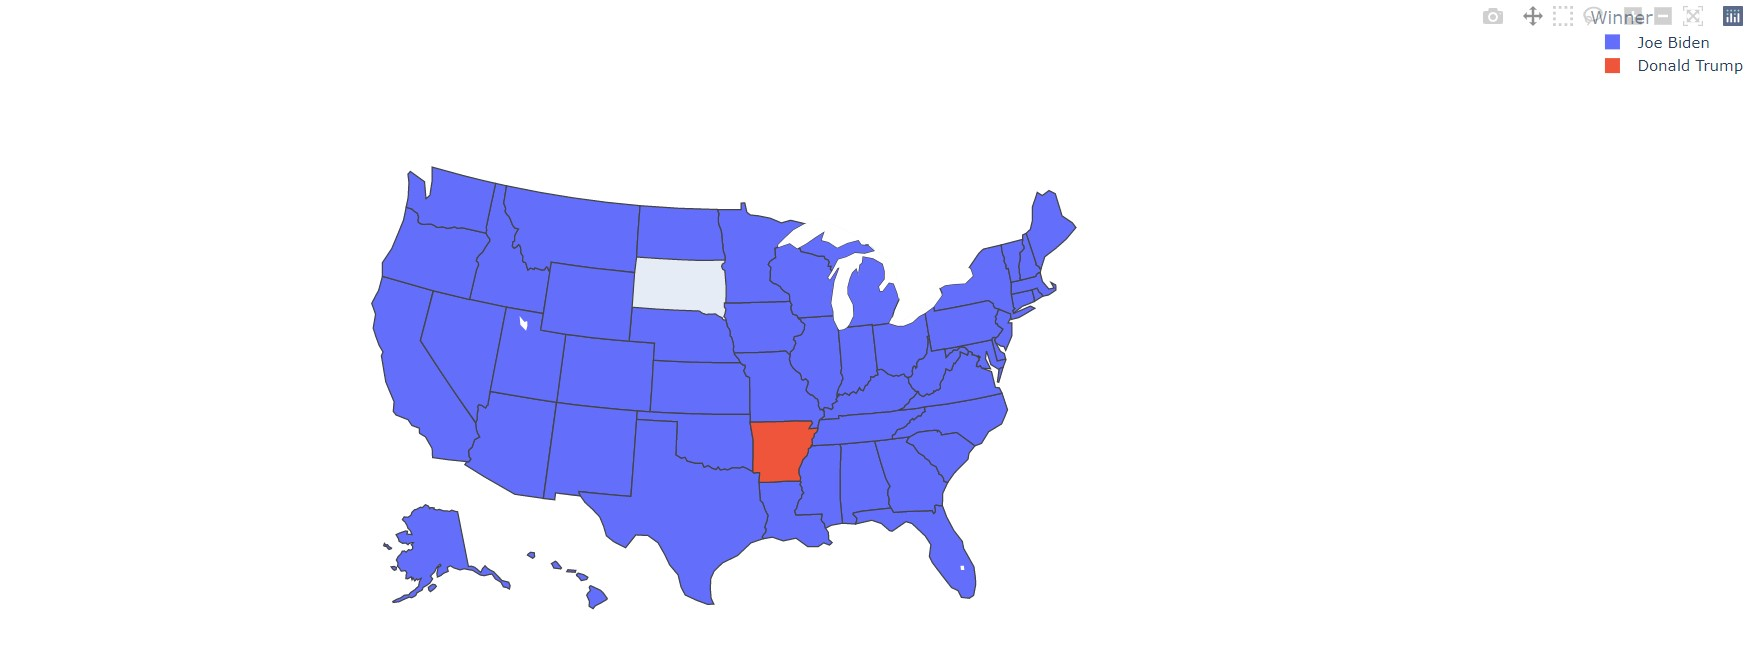

###**2020 Election results**
https://www.cnn.com/election/2020/results/president

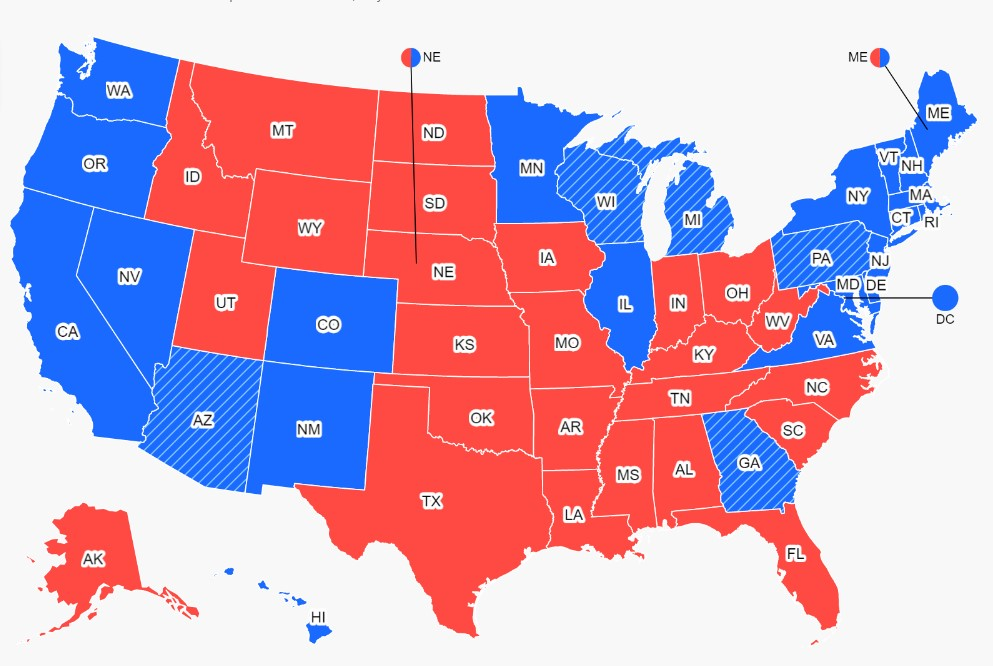

##**CONCLUSION**

We observed a disparity in the actual election results of 2020 and the sentiment analysis of our tweets data. Some of the reasons for this disparity could be:
1. Inaccuracies in sentiment analysis
- Sentiment labeling with Textblob/ GCP NL AI was far from perfect, we could see many cases where the sentiments were misclassified according to our interpretation of the tweets.
- Along with that, the best classifier accuracy was ~85%, which contributes to some loss of accuracy
2. Social media sentiment vs actual voting patterns
- There could be a significant difference in sentiments expressed on social media and actual voting patterns. For example, a common observation is that young people are very vocal on social media, but only a small percentage vote, the converse is true for older people, they vote in higher percentages but express less on social media
3. Inadequate data
- The dataset is small, especially considering there could be millions of voters from each state but only hundreds or in many cases single/double digit number of tweets in our data
- With a larger dataset of millions of tweets, we could perform a more accurate and meaningful analysis